# Exploratory Data Analysis on the Training Data

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from PIL import Image, ImageEnhance
import skimage.util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns

In [ ]:
def load_footwear_dataset(path):
    npz_file = os.path.join(path, 'train_A.npz')

    if not os.path.isfile(npz_file):
        raise FileNotFoundError(f"{npz_file} not found.")

    print(f"Loading dataset from {npz_file}")
    data = np.load(npz_file)

    images = data['X']  # channel-first format (N, 3, H, W)
    labels = data['y']

    print(f"Loaded: {images.shape} {labels.shape}")

    # Convert from (N, C, H, W) to (N, H, W, C)
    if images.shape[1] == 3:
        images = np.transpose(images, (0, 2, 3, 1))
        print(f"Converted to channel-last format: {images.shape}")

    categories = ['Boot', 'Sandal', 'Shoe']

    return images, labels, categories

In [9]:
dataset_path = ""
images, labels, categories = load_footwear_dataset(dataset_path)

Loading dataset from train_A.npz
Loaded: (12000, 224, 224, 3) (12000,)


Dataset is completely balanced, meets the requirements of the assignment as well.

In [12]:
def dataset_summary(images, labels, categories):
    print("Summary:")
    print("Total:", len(images))
    print("Distribution:", Counter(labels))

    stats = {}

    for cat in categories:
        idxs = np.where(labels == cat)[0]
        sample = images[idxs[:min(200, len(idxs))]]

        brightness = []
        edge_density = []

        for im in sample:
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            brightness.append(np.mean(gray))
            edges = cv2.Canny(gray, 50, 150)
            edge_density.append(np.mean(edges > 0))

        stats[cat] = {
            "brightness": np.mean(brightness),
            "edge_density": np.mean(edge_density)
        }
        print(f"{cat}: avg brightness={stats[cat]['brightness']:.1f}, edge density={stats[cat]['edge_density']:.3f}")

    return stats

In [13]:
stats = dataset_summary(images, labels, categories)

Summary:
Total: 12000
Distribution: Counter({np.str_('Boot'): 4000, np.str_('Sandal'): 4000, np.str_('Shoe'): 4000})
Boot: avg brightness=197.3, edge density=0.057
Sandal: avg brightness=202.8, edge density=0.071
Shoe: avg brightness=189.5, edge density=0.071


Sandals are brighter overall.

Boots have lowest edge density.

Shoes fall in between.

In [ ]:
def plot_color_histograms(images, labels, categories, sample_per_class=200):
    plt.figure(figsize=(12, 6))

    for i, cat in enumerate(categories):
        # Selecting indices where label matches category name
        idxs = np.where(labels == cat)[0]

        if len(idxs) == 0:
            print(f"Warning: No images found for category '{cat}'")
            continue

        idxs = np.random.choice(idxs, size=min(sample_per_class, len(idxs)), replace=False)
        hsv_vals = []

        for idx in idxs:
            hsv = cv2.cvtColor(images[idx], cv2.COLOR_BGR2HSV)
            hsv_vals.append(np.mean(hsv, axis=(0, 1)))  # avg [H, S, V] per image

        hsv_vals = np.array(hsv_vals)

        plt.subplot(1, len(categories), i + 1)
        plt.hist(hsv_vals[:, 0], bins=30, color='red', alpha=0.6, label='Hue')
        plt.hist(hsv_vals[:, 1], bins=30, color='green', alpha=0.6, label='Saturation')
        plt.hist(hsv_vals[:, 2], bins=30, color='blue', alpha=0.6, label='Value')
        plt.title(f"{cat} HSV dist")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()

    plt.tight_layout()
    plt.show()

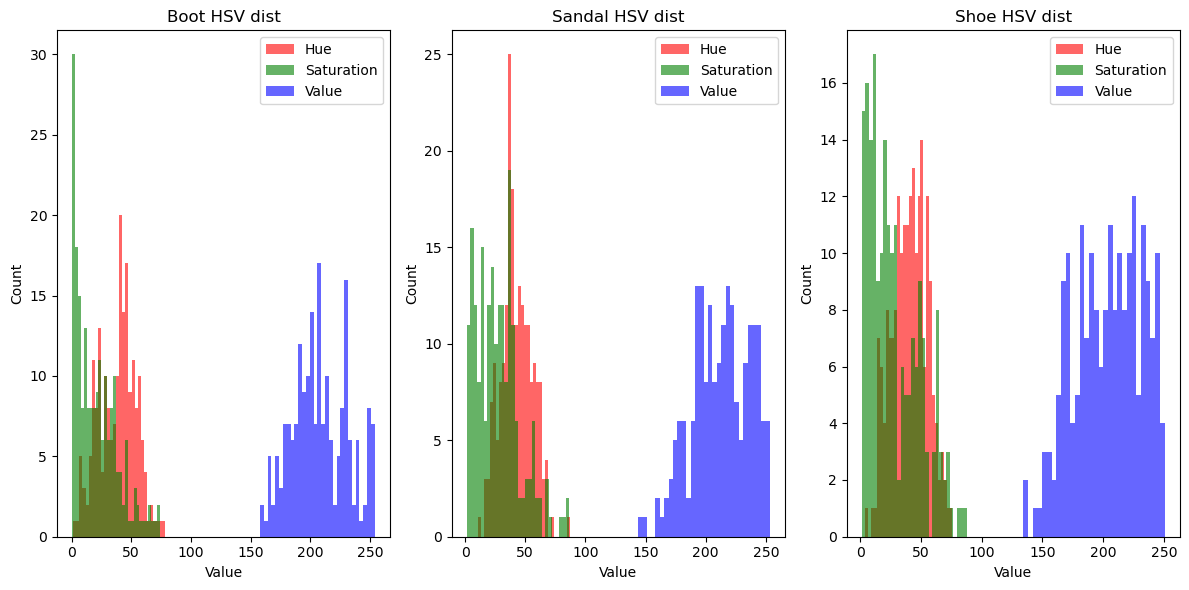

In [15]:
plot_color_histograms(images, labels, categories, sample_per_class=200)

In [ ]:
def plot_class_balance(labels, categories):
    counts = Counter(labels)
    data = {
        "Class": categories,
        "Count": [counts[cat] for cat in categories]
    }

    plt.figure(figsize=(5, 4))
    sns.barplot(
        x="Class",
        y="Count",
        hue="Class",
        data=data,
        palette="pastel",
        legend=False
    )
    plt.title("Class Distribution")
    plt.ylabel("Image Count")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()

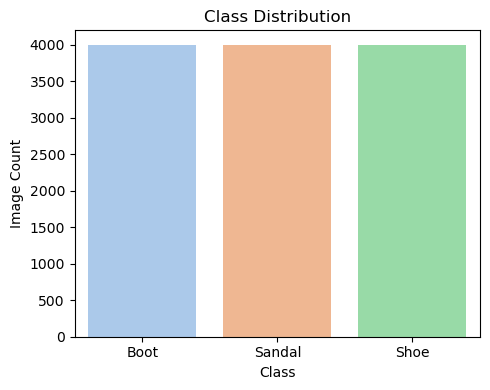

In [19]:
plot_class_balance(labels, categories)

Balanced train Dataset based on the classes.

In [ ]:
def check_image_quality(images, labels=None, categories=None, threshold_low=50):
    avg_brightness = [
        np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        for img in images
    ]

    dark = [i for i, b in enumerate(avg_brightness) if b < threshold_low]

    print(f"Total dark images (<{threshold_low} brightness): {len(dark)}")

    if labels is not None and categories is not None:
        dark_labels = [labels[i] for i in dark]
        dark_counts = Counter(dark_labels)

        print("Dark images per class:")
        for cat in categories:
            print(f"  {cat}: {dark_counts.get(cat, 0)}")

    return dark

In [24]:
dark = check_image_quality(images, threshold_low=100)

Total dark images (<100 brightness): 0


No extremely dark images, due to white backgrounds in product photography.

Models may rely excessively on background brightness, not footwear details, must be explored in preprocessing.

#### For Dataset B (Augmented Images)

In [ ]:
def load_footwear_dataset_for_DataB(path):
    npz_file = os.path.join(path, 'train_B.npz')

    if not os.path.isfile(npz_file):
        raise FileNotFoundError(f"{npz_file} not found.")

    print(f"Loading dataset from {npz_file}")
    data = np.load(npz_file)

    images = data['X']  # channel-first format (N, 3, H, W)
    labels = data['y']

    print(f"Loaded: {images.shape} {labels.shape}")

    # Convert from (N, C, H, W) to (N, H, W, C)
    if images.shape[1] == 3:
        images = np.transpose(images, (0, 2, 3, 1))
        print(f"Converted to channel-last format: {images.shape}")
        
    categories = ['Boot', 'Sandal', 'Shoe']

    return images, labels, categories

In [31]:
dataset_path = ""
images, labels, categories = load_footwear_dataset_for_DataB(dataset_path)

Loading dataset from train_B.npz
Loaded: (12000, 224, 224, 3) (12000,)


In [32]:
stats = dataset_summary(images, labels, categories)

Summary:
Total: 12000
Distribution: Counter({np.str_('Boot'): 4000, np.str_('Sandal'): 4000, np.str_('Shoe'): 4000})
Boot: avg brightness=160.0, edge density=0.081
Sandal: avg brightness=164.5, edge density=0.090
Shoe: avg brightness=148.9, edge density=0.093


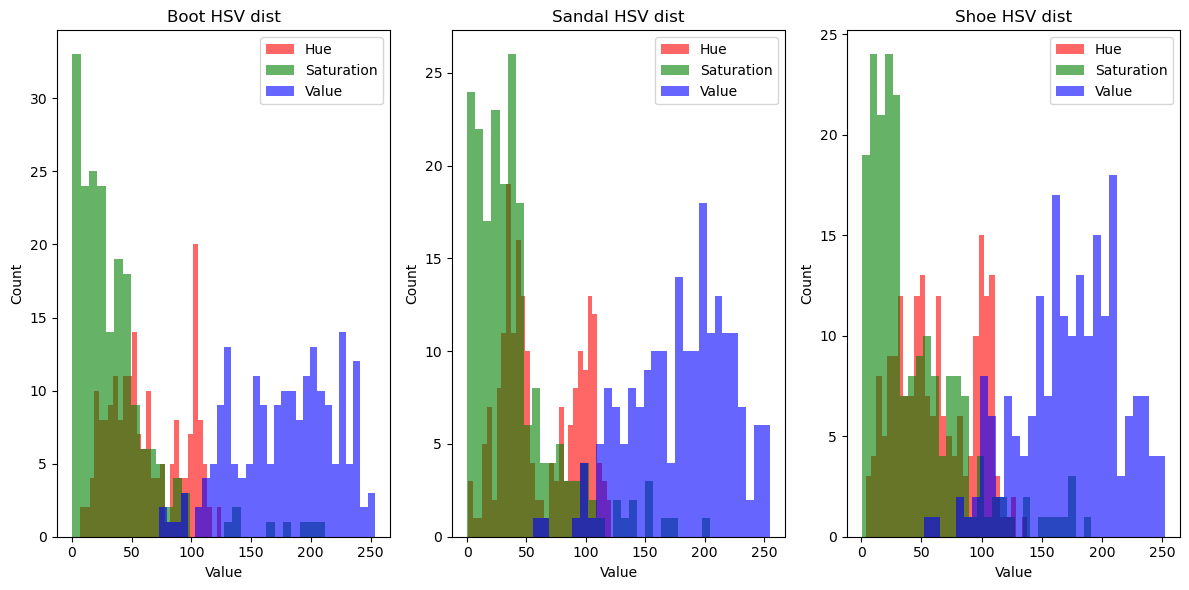

In [33]:
plot_color_histograms(images, labels, categories, sample_per_class=200)

In [34]:
dark = check_image_quality(images, threshold_low=100)

Total dark images (<100 brightness): 1414
